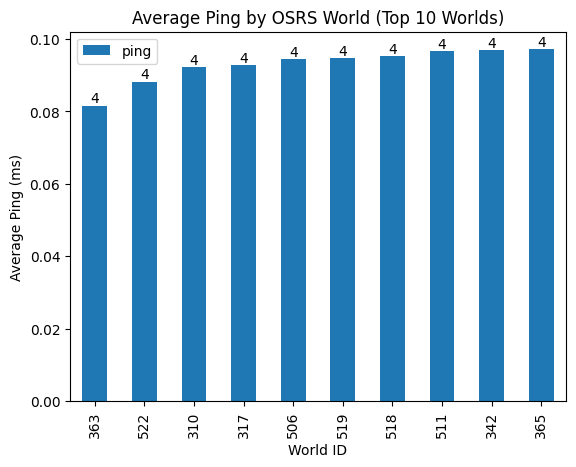

In [15]:
import pandas as pd
from utils import schema
import sqlalchemy as sa
import matplotlib.pyplot as plt

# create the database
engine = sa.create_engine("sqlite:///data/world_data.db")
schema.Base.metadata.create_all(engine)
# insert the data into the database
with schema.get_session(engine=engine) as session:
    ping_data = session.query(schema.PingData).all()
    df = pd.DataFrame([x.to_dict() for x in ping_data])
    # plot the data for the lowest average ping for the top 10 worlds
    top10 = df.groupby("world_id").agg(count=("ping", "size"), ping=("ping", "mean")).sort_values("ping").head(10)
    # mean().sort_values("ping").head(10)
    ax = top10.plot(kind="bar", y="ping")
    # add labels with the number of data points for each world
    for i, v in enumerate(zip(top10["ping"], top10["count"])):
        # add a label at the top of each bar with the number of data points used to calculate the average
        ax.text(i, v[0], f"{v[1]}", ha="center", va="bottom")
    plt.ylabel("Average Ping (ms)")
    plt.title(f"Average Ping by OSRS World (Top 10 Worlds)")
    plt.xlabel("World ID")
    plt.show()